In [3]:
from keras.preprocessing import sequence
from keras.models import Sequential, Model
from keras.layers import GRU, Dense, Dropout, Input, concatenate
from keras.utils import np_utils
from keras.optimizers import Adam
import json
import pandas as pd
import numpy as np

Using TensorFlow backend.


In [129]:
# variable
words = [
    'come quickly', 'emergency', 'father', 'fever', 'good luck',
    'headache', 'hello', 'help', 'hi', 'hungry',
    'like', 'mother', 'mother_father', 'mother_mother', 'not ok',
    'quickly', 'sorry', 'tomorrow', 'yogurt'
]
data_per_word = 27
data_length = 1 * data_per_word * len(words)
timesteps = 50
dimensions = 22

In [5]:
def get_feature(frame):
    finger_name = ['thumb', 'index', 'middle', 'ring', 'pinky']
#     coordinate = ['x', 'y', 'z']
    fingertip_pos = np.zeros([2, 5, 3]) # [cooridinates x fingers]
    feature = np.zeros([22])
    hand_pos = np.zeros([12])
#     finger_tip = {}
    if 'right' in frame['hands']:
        hand_pos[0:6] = np.array([frame['hands']['right']['hand_palm_position'][0],
                                  frame['hands']['right']['hand_palm_position'][1],
                                  frame['hands']['right']['hand_palm_position'][2],
                                  frame['hands']['right']['yaw'], 
                                  frame['hands']['right']['roll'], 
                                  frame['hands']['right']['pitch']])
        for idx, finger in enumerate(finger_name):
#             fingertip_pos[2 + idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
            fingertip_pos[0, idx, :] = np.array(frame['hands']['right']['fingers'][finger]['bones']['distal']['next_joint'])
    if 'left' in frame['hands']:
        hand_pos[6:12] = np.array([frame['hands']['left']['hand_palm_position'][0],
                                   frame['hands']['left']['hand_palm_position'][1],
                                   frame['hands']['left']['hand_palm_position'][2],
                                   frame['hands']['left']['yaw'], 
                                   frame['hands']['left']['roll'], 
                                   frame['hands']['left']['pitch']])
#         fingertip_pos[8, :] = np.array(frame['hands']['left']['hand_palm_position'])
        for idx, finger in enumerate(finger_name):
#             fingertip_pos[4 + 5 + idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
            fingertip_pos[1, idx, :] = np.array(frame['hands']['left']['fingers'][finger]['bones']['distal']['next_joint'])
    fingertip_pos_shift = np.roll(fingertip_pos, 1, axis=1)
    feature[0:10] = np.linalg.norm(fingertip_pos - fingertip_pos_shift, axis=2).reshape(10)
    feature[10:22] = hand_pos

    return feature

In [6]:
def get_timestep_from_data(json_data, pick_frame_every_no):
    timestep = np.zeros([0, dimensions])
    curr_idx = 0
    
    for frame_no, frame in enumerate(json_data):
        if frame_no % pick_frame_every_no != 0 or not frame['hands']: #check if frame[hands] is null
            continue
        feature = get_feature(frame)
#             for idx, fingertip_pos in enumerate(fingertips_pos):
        timestep = np.vstack((timestep, feature))
        curr_idx += 1
        
    return timestep

    

In [7]:
def get_timesteps(json_data, pick_frame_every_no): 
    timesteps = np.zeros([0, dimensions])
    for frame_no, frame in enumerate(json_data):
        if frame_no % pick_frame_every_no != 0 or not frame['hands']:
            continue
        feature = get_feature(frame)
        timesteps = np.vstack((timesteps, feature))
    return timesteps

In [8]:
def get_fake_speedup_timesteps_1(percent, json_data, pick_frame_every_no):
    return get_timesteps(json_data, pick_frame_every_no*(100+percent)//100)

In [116]:
def get_fake_speedup_timesteps_2(percent, old_timesteps, old_pick_frame_every_no):
    timesteps = np.zeros([0, dimensions])
    pick_frame_every_no = old_pick_frame_every_no*(100+percent)//100
    timesteps_length = (old_timesteps.shape[0] * old_pick_frame_every_no) // pick_frame_every_no
    
    for new_index in range(1, timesteps_length):
        start_old_index = (new_index * pick_frame_every_no) // old_pick_frame_every_no
        x1 = old_pick_frame_every_no*start_old_index
        x2 = old_pick_frame_every_no*(start_old_index + 1)
        h1, h2 = old_timesteps[start_old_index : start_old_index + 2]
        _x = (new_index * pick_frame_every_no)
        
        feature = ((_x-x1)/(x2-x1))*(h2-h1) + h1
        
        timesteps = np.vstack((timesteps, feature))
        
    return timesteps
        
    

In [10]:
max_frame = 0
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        if max_frame < len(json_data):
            max_frame = len(json_data)

In [53]:
speedup = 10
pick_frame_every_no = int((max_frame * (speedup < 0 and (100-speedup)/100 or 1)) // 50 + 1)

In [130]:
x = np.zeros([0, timesteps, dimensions])
y = np.zeros([0])
for word_no, word in enumerate(words):
    for data_no in range(data_per_word):
        try:
            with open("./record/{}/json_{}.txt".format(word, data_no)) as json_data:
                json_data = json.load(json_data)
        except Exception as s:
            print ('error log:', s)
        
        _timesteps = get_timesteps(json_data, pick_frame_every_no)
        __timesteps = np.vstack((_timesteps, np.zeros([timesteps - _timesteps.shape[0], dimensions])))
        x = np.vstack((x, [__timesteps]))
        y = np.append(y, word_no)
        
#         _timesteps = get_fake_speedup_timesteps_2(+10, _timesteps, pick_frame_every_no)
#         __timesteps = np.vstack((_timesteps, np.zeros([timesteps - _timesteps.shape[0], dimensions])))
#         x = np.vstack((x, [__timesteps]))
#         y = np.append(y, word_no)

In [131]:
x_std = x.std(axis=(0,1), keepdims=True)
x_mean = x.mean(axis=(0,1), keepdims=True)
x_norm = (x-x_mean)/x_std
# x_norm = (x-x_min)/(x_max-x_min)
# x_norm = 2*(x-(x_max+x_min)/2)/(x_max-x_min)

In [132]:
x_train = np.zeros([data_length * 2 // 3, timesteps, dimensions])
y_train = np.zeros([data_length * 2 // 3])
x_test = np.zeros([data_length // 3, timesteps, dimensions])
y_test = np.zeros([data_length // 3])
for idx in range(data_length):
    if idx % 3 == 2:
        x_test[idx // 3] = x_norm[idx]
        y_test[idx // 3] = y[idx]
    else:
        x_train[idx - idx // 3] = x_norm[idx]
        y_train[idx - idx // 3] = y[idx]

In [133]:
shuffle_train = np.arange(len(x_train))
np.random.shuffle(shuffle_train)
x_train_shuffle = np.zeros([data_length * 2 // 3, timesteps, dimensions])
y_train_shuffle = np.zeros([data_length * 2 // 3])
for idx, item in enumerate(shuffle_train):
    x_train_shuffle[idx] = x_train[item]
    y_train_shuffle[idx] = y_train[item]

In [134]:
# encoding label
Y_train_shuffle = np_utils.to_categorical(y_train_shuffle, len(words))
Y_test = np_utils.to_categorical(y_test, len(words))

In [135]:
fingers = Input(shape=(timesteps, dimensions), name='fingers')
fingers_layers = GRU(64, activation='tanh', recurrent_activation='hard_sigmoid', dropout=0.2, recurrent_dropout=0.2)(fingers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
fingers_layers = Dense(64, activation='relu')(fingers_layers)
fingers_layers = Dropout(0.2)(fingers_layers)
output_layer = Dense(len(words), activation='softmax')(fingers_layers)
model = Model(inputs=fingers, outputs=output_layer)
adam = Adam(lr=0.01, decay=0.0005)
model.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [136]:
history = model.fit(x_train_shuffle, Y_train_shuffle,validation_data=(x_test, Y_test), epochs=1000, batch_size=8, shuffle=True)

Train on 342 samples, validate on 171 samples
Epoch 1/1000
342/342 [==============================] - 2s 6ms/step - loss: 2.9868 - acc: 0.0380 - val_loss: 2.9717 - val_acc: 0.0526
Epoch 2/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.9794 - acc: 0.0409 - val_loss: 2.9474 - val_acc: 0.0526
Epoch 3/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.9661 - acc: 0.0585 - val_loss: 2.9429 - val_acc: 0.0292
Epoch 4/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.9616 - acc: 0.0409 - val_loss: 2.9479 - val_acc: 0.0526
Epoch 5/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.9449 - acc: 0.0614 - val_loss: 2.8868 - val_acc: 0.1111
Epoch 6/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.8992 - acc: 0.0497 - val_loss: 2.8532 - val_acc: 0.0760
Epoch 7/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.8699 - acc: 0.0585 - val_loss: 2.8642 - val_acc: 0.0760
Epoch 8/1000
342

342/342 [==============================] - 1s 3ms/step - loss: 2.5168 - acc: 0.1374 - val_loss: 2.3941 - val_acc: 0.1988
Epoch 62/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4623 - acc: 0.1725 - val_loss: 2.3419 - val_acc: 0.2105
Epoch 63/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5651 - acc: 0.1257 - val_loss: 2.3387 - val_acc: 0.1988
Epoch 64/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5685 - acc: 0.1462 - val_loss: 2.3501 - val_acc: 0.2164
Epoch 65/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4861 - acc: 0.1491 - val_loss: 2.3283 - val_acc: 0.2222
Epoch 66/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4841 - acc: 0.1228 - val_loss: 2.3437 - val_acc: 0.1988
Epoch 67/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4543 - acc: 0.1520 - val_loss: 2.2941 - val_acc: 0.2281
Epoch 68/1000
342/342 [==============================] - 1s 3ms/step 

342/342 [==============================] - 1s 3ms/step - loss: 2.6376 - acc: 0.1345 - val_loss: 2.5761 - val_acc: 0.1579
Epoch 122/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.6693 - acc: 0.1374 - val_loss: 2.5975 - val_acc: 0.1637
Epoch 123/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.7190 - acc: 0.1053 - val_loss: 2.6405 - val_acc: 0.1170
Epoch 124/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.6916 - acc: 0.1404 - val_loss: 2.6266 - val_acc: 0.1462
Epoch 125/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.6523 - acc: 0.1433 - val_loss: 2.5783 - val_acc: 0.1637
Epoch 126/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.6243 - acc: 0.1345 - val_loss: 2.5323 - val_acc: 0.1988
Epoch 127/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.6554 - acc: 0.1433 - val_loss: 2.5128 - val_acc: 0.1871
Epoch 128/1000
342/342 [==============================] - 1s 3m

342/342 [==============================] - 1s 3ms/step - loss: 2.6037 - acc: 0.1433 - val_loss: 2.5002 - val_acc: 0.1930
Epoch 182/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5893 - acc: 0.1579 - val_loss: 2.4879 - val_acc: 0.2047
Epoch 183/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.6153 - acc: 0.1404 - val_loss: 2.4902 - val_acc: 0.1988
Epoch 184/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.6370 - acc: 0.1550 - val_loss: 2.5156 - val_acc: 0.2339
Epoch 185/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5911 - acc: 0.1608 - val_loss: 2.4844 - val_acc: 0.1930
Epoch 186/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.6325 - acc: 0.1667 - val_loss: 2.5035 - val_acc: 0.2164
Epoch 187/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.6030 - acc: 0.1579 - val_loss: 2.4836 - val_acc: 0.2164
Epoch 188/1000
342/342 [==============================] - 1s 3m

342/342 [==============================] - 1s 3ms/step - loss: 2.5457 - acc: 0.1550 - val_loss: 2.4451 - val_acc: 0.2222
Epoch 242/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5842 - acc: 0.1754 - val_loss: 2.4598 - val_acc: 0.2398
Epoch 243/1000
342/342 [==============================] - 1s 4ms/step - loss: 2.5445 - acc: 0.1637 - val_loss: 2.4684 - val_acc: 0.2398
Epoch 244/1000
342/342 [==============================] - 1s 4ms/step - loss: 2.6042 - acc: 0.1667 - val_loss: 2.4454 - val_acc: 0.2398
Epoch 245/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5269 - acc: 0.1550 - val_loss: 2.4174 - val_acc: 0.2398
Epoch 246/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.6020 - acc: 0.1550 - val_loss: 2.4275 - val_acc: 0.2398
Epoch 247/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5610 - acc: 0.1520 - val_loss: 2.4246 - val_acc: 0.2515
Epoch 248/1000
342/342 [==============================] - 1s 3m

342/342 [==============================] - 1s 3ms/step - loss: 2.4916 - acc: 0.1813 - val_loss: 2.3544 - val_acc: 0.2164
Epoch 302/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5091 - acc: 0.1784 - val_loss: 2.3644 - val_acc: 0.2164
Epoch 303/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5766 - acc: 0.1491 - val_loss: 2.3590 - val_acc: 0.1988
Epoch 304/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5521 - acc: 0.1345 - val_loss: 2.3778 - val_acc: 0.2105
Epoch 305/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5287 - acc: 0.1462 - val_loss: 2.3698 - val_acc: 0.2105
Epoch 306/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5116 - acc: 0.1491 - val_loss: 2.3638 - val_acc: 0.1813
Epoch 307/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5234 - acc: 0.1813 - val_loss: 2.3530 - val_acc: 0.2047
Epoch 308/1000
342/342 [==============================] - 1s 3m

342/342 [==============================] - 1s 3ms/step - loss: 2.5049 - acc: 0.1696 - val_loss: 2.4170 - val_acc: 0.2222
Epoch 362/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5265 - acc: 0.1462 - val_loss: 2.4040 - val_acc: 0.2339
Epoch 363/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5393 - acc: 0.1696 - val_loss: 2.4253 - val_acc: 0.2398
Epoch 364/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5463 - acc: 0.1520 - val_loss: 2.4023 - val_acc: 0.2281
Epoch 365/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4311 - acc: 0.1696 - val_loss: 2.3915 - val_acc: 0.2281
Epoch 366/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4745 - acc: 0.1520 - val_loss: 2.3840 - val_acc: 0.2281
Epoch 367/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4962 - acc: 0.1637 - val_loss: 2.3925 - val_acc: 0.2164
Epoch 368/1000
342/342 [==============================] - 1s 3m

342/342 [==============================] - 1s 3ms/step - loss: 2.5400 - acc: 0.1608 - val_loss: 2.3815 - val_acc: 0.2573
Epoch 422/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4328 - acc: 0.1725 - val_loss: 2.3493 - val_acc: 0.2456
Epoch 423/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5042 - acc: 0.1813 - val_loss: 2.3533 - val_acc: 0.2456
Epoch 424/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4471 - acc: 0.1579 - val_loss: 2.3620 - val_acc: 0.2749
Epoch 425/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5444 - acc: 0.1637 - val_loss: 2.3472 - val_acc: 0.2573
Epoch 426/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4751 - acc: 0.1550 - val_loss: 2.3333 - val_acc: 0.2573
Epoch 427/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4666 - acc: 0.1696 - val_loss: 2.3249 - val_acc: 0.2749
Epoch 428/1000
342/342 [==============================] - 1s 4m

342/342 [==============================] - 1s 3ms/step - loss: 2.5287 - acc: 0.2047 - val_loss: 2.3378 - val_acc: 0.2398
Epoch 482/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4837 - acc: 0.1637 - val_loss: 2.3344 - val_acc: 0.2398
Epoch 483/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5025 - acc: 0.1725 - val_loss: 2.3401 - val_acc: 0.2515
Epoch 484/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4951 - acc: 0.1959 - val_loss: 2.3364 - val_acc: 0.2573
Epoch 485/1000
342/342 [==============================] - 1s 4ms/step - loss: 2.4723 - acc: 0.1667 - val_loss: 2.3169 - val_acc: 0.2456
Epoch 486/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4095 - acc: 0.1813 - val_loss: 2.3149 - val_acc: 0.2456
Epoch 487/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5204 - acc: 0.1696 - val_loss: 2.3310 - val_acc: 0.2281
Epoch 488/1000
342/342 [==============================] - 1s 3m

342/342 [==============================] - 1s 3ms/step - loss: 2.5065 - acc: 0.1842 - val_loss: 2.3408 - val_acc: 0.2690
Epoch 542/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4096 - acc: 0.1959 - val_loss: 2.3246 - val_acc: 0.2515
Epoch 543/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5327 - acc: 0.1784 - val_loss: 2.3265 - val_acc: 0.2456
Epoch 544/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5766 - acc: 0.1784 - val_loss: 2.3428 - val_acc: 0.2456
Epoch 545/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5032 - acc: 0.1608 - val_loss: 2.3424 - val_acc: 0.2573
Epoch 546/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4313 - acc: 0.1667 - val_loss: 2.3431 - val_acc: 0.2515
Epoch 547/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5071 - acc: 0.1667 - val_loss: 2.3367 - val_acc: 0.2398
Epoch 548/1000
342/342 [==============================] - 1s 3m

342/342 [==============================] - 1s 3ms/step - loss: 2.4190 - acc: 0.1813 - val_loss: 2.3112 - val_acc: 0.2398
Epoch 602/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4577 - acc: 0.1930 - val_loss: 2.3199 - val_acc: 0.2398
Epoch 603/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4673 - acc: 0.1842 - val_loss: 2.3242 - val_acc: 0.2398
Epoch 604/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4726 - acc: 0.1667 - val_loss: 2.3187 - val_acc: 0.2398
Epoch 605/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4670 - acc: 0.2105 - val_loss: 2.3171 - val_acc: 0.2398
Epoch 606/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4166 - acc: 0.2164 - val_loss: 2.3179 - val_acc: 0.2632
Epoch 607/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4355 - acc: 0.1959 - val_loss: 2.3152 - val_acc: 0.2573
Epoch 608/1000
342/342 [==============================] - 1s 3m

342/342 [==============================] - 1s 3ms/step - loss: 2.4263 - acc: 0.2018 - val_loss: 2.3133 - val_acc: 0.2281
Epoch 662/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4222 - acc: 0.2018 - val_loss: 2.3200 - val_acc: 0.2047
Epoch 663/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5181 - acc: 0.1959 - val_loss: 2.3121 - val_acc: 0.2222
Epoch 664/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.3961 - acc: 0.2018 - val_loss: 2.3097 - val_acc: 0.2164
Epoch 665/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4603 - acc: 0.1813 - val_loss: 2.3084 - val_acc: 0.2105
Epoch 666/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4265 - acc: 0.2164 - val_loss: 2.3162 - val_acc: 0.2339
Epoch 667/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4503 - acc: 0.1842 - val_loss: 2.3083 - val_acc: 0.2164
Epoch 668/1000
342/342 [==============================] - 1s 3m

342/342 [==============================] - 1s 3ms/step - loss: 2.4639 - acc: 0.2076 - val_loss: 2.3203 - val_acc: 0.2339
Epoch 722/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4338 - acc: 0.1871 - val_loss: 2.3153 - val_acc: 0.2456
Epoch 723/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4857 - acc: 0.1813 - val_loss: 2.3124 - val_acc: 0.2398
Epoch 724/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4539 - acc: 0.1813 - val_loss: 2.3147 - val_acc: 0.2222
Epoch 725/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5057 - acc: 0.1754 - val_loss: 2.3164 - val_acc: 0.2398
Epoch 726/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4238 - acc: 0.1901 - val_loss: 2.3131 - val_acc: 0.2398
Epoch 727/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4882 - acc: 0.1784 - val_loss: 2.3082 - val_acc: 0.2222
Epoch 728/1000
342/342 [==============================] - 1s 3m

342/342 [==============================] - 1s 3ms/step - loss: 2.4283 - acc: 0.2222 - val_loss: 2.3118 - val_acc: 0.2515
Epoch 782/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4675 - acc: 0.1842 - val_loss: 2.3126 - val_acc: 0.2632
Epoch 783/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4002 - acc: 0.2193 - val_loss: 2.3046 - val_acc: 0.2632
Epoch 784/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4301 - acc: 0.1842 - val_loss: 2.3064 - val_acc: 0.2573
Epoch 785/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.3652 - acc: 0.2281 - val_loss: 2.2967 - val_acc: 0.2807
Epoch 786/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4112 - acc: 0.2105 - val_loss: 2.3036 - val_acc: 0.2690
Epoch 787/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.3972 - acc: 0.2485 - val_loss: 2.2993 - val_acc: 0.2632
Epoch 788/1000
342/342 [==============================] - 1s 3m

342/342 [==============================] - 1s 3ms/step - loss: 2.4789 - acc: 0.1550 - val_loss: 2.3140 - val_acc: 0.2573
Epoch 842/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4793 - acc: 0.1725 - val_loss: 2.3143 - val_acc: 0.2456
Epoch 843/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4777 - acc: 0.1667 - val_loss: 2.3129 - val_acc: 0.2515
Epoch 844/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5101 - acc: 0.1754 - val_loss: 2.3106 - val_acc: 0.2632
Epoch 845/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4721 - acc: 0.1813 - val_loss: 2.3207 - val_acc: 0.2749
Epoch 846/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4232 - acc: 0.1988 - val_loss: 2.3172 - val_acc: 0.2690
Epoch 847/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4737 - acc: 0.1930 - val_loss: 2.3195 - val_acc: 0.2749
Epoch 848/1000
342/342 [==============================] - 1s 3m

342/342 [==============================] - 1s 3ms/step - loss: 2.4263 - acc: 0.1930 - val_loss: 2.3058 - val_acc: 0.2456
Epoch 902/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4049 - acc: 0.1930 - val_loss: 2.3088 - val_acc: 0.2339
Epoch 903/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4459 - acc: 0.1930 - val_loss: 2.3062 - val_acc: 0.2456
Epoch 904/1000
342/342 [==============================] - 1s 4ms/step - loss: 2.4670 - acc: 0.1988 - val_loss: 2.3129 - val_acc: 0.2281
Epoch 905/1000
342/342 [==============================] - 1s 4ms/step - loss: 2.4546 - acc: 0.1930 - val_loss: 2.3090 - val_acc: 0.2222
Epoch 906/1000
342/342 [==============================] - 1s 4ms/step - loss: 2.4527 - acc: 0.2105 - val_loss: 2.3146 - val_acc: 0.2281
Epoch 907/1000
342/342 [==============================] - 1s 4ms/step - loss: 2.4592 - acc: 0.1930 - val_loss: 2.3289 - val_acc: 0.2281
Epoch 908/1000
342/342 [==============================] - 1s 3m

342/342 [==============================] - 1s 3ms/step - loss: 2.4422 - acc: 0.1842 - val_loss: 2.3118 - val_acc: 0.2515
Epoch 962/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4493 - acc: 0.1959 - val_loss: 2.3147 - val_acc: 0.2398
Epoch 963/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4477 - acc: 0.1901 - val_loss: 2.3214 - val_acc: 0.2515
Epoch 964/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.3976 - acc: 0.2193 - val_loss: 2.3042 - val_acc: 0.2573
Epoch 965/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4467 - acc: 0.1871 - val_loss: 2.3125 - val_acc: 0.2573
Epoch 966/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.5144 - acc: 0.1725 - val_loss: 2.3188 - val_acc: 0.2749
Epoch 967/1000
342/342 [==============================] - 1s 3ms/step - loss: 2.4724 - acc: 0.1784 - val_loss: 2.3238 - val_acc: 0.2515
Epoch 968/1000
342/342 [==============================] - 1s 3m

In [137]:
score, acc = model.evaluate(x_test, Y_test)
print('Test score:', score)
print('Test accuracy:', acc)

171/171 [==============================] - 0s 393us/step
Test score: 2.34977898263
Test accuracy: 0.263157894911


In [138]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


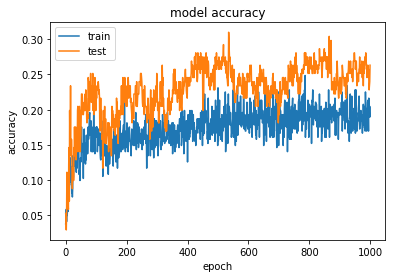

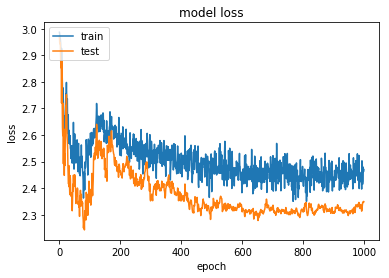

In [139]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()